<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Reproducible Papers - Icy Moon Seismology</div>
        </div>
    </div>
</div>

---

# Figure 8: IceVI measureability

This notebook is part of the supplementary materials for the Icy Moon paper and reproduces figure 6.

This notebook creates the comparison between P and S spectra for Titan models with and without a high pressure ice layer below the ocean. Requires matplotlib >= 1.5, ObsPy and Instaseis.

##### Authors:
* Simon Stähler ([@sstaehler](https://github.com/sstaehler))

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from obspy import taup
from obspy.signal.util import next_pow_2
import instaseis
%matplotlib inline
import matplotlib.mlab as mlab
mpl.rcParams['mathtext.default']='regular'

# Define database locations

In [5]:
db_iceVI = instaseis.open_db('http://instaseis.ethz.ch/icy_ocean_worlds/Tit046km-33pNH-hQ_noiceVI_2s')
db_noice = instaseis.open_db('http://instaseis.ethz.ch/icy_ocean_worlds/Gan126km-00pMS-hQ_hyd30km_4s')

/opt/instaseis/instaseis/database_interfaces/remote_instaseis_db.py:60: InstaseisWarning: Instaseis versions on server (0.1.1-55-ga28cf) and on your local client (1.1.0-1-g0f53) differ and thus things might not work as expected.
  warnings.warn(msg, InstaseisWarning)


# Create plot

512 1024


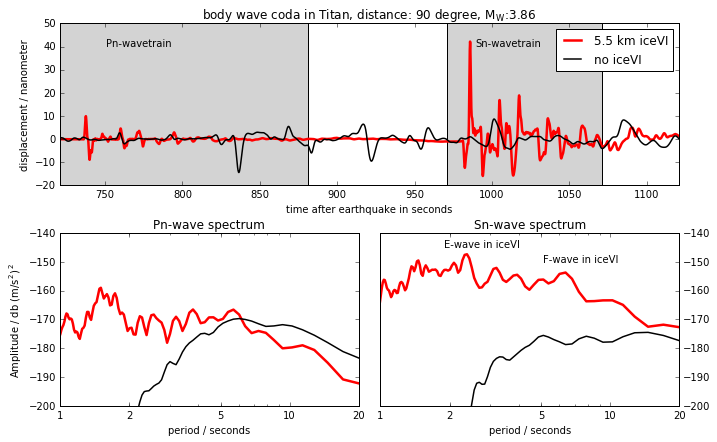

In [6]:
taup_model = taup.TauPyModel('Fig_8/Titan.npz')
d_ice = taup_model.model.get_branch_depths()[1]
d_water = taup_model.model.get_branch_depths()[3]
    
fig = plt.figure(figsize=(10, 6))
ax_seis = fig.add_axes([0.08, 0.59, 0.86, 0.375])
ax_spec_P = fig.add_axes([0.08, 0.08, 0.415, 0.4])
ax_spec_S = fig.add_axes([0.525, 0.08, 0.415, 0.4])

depth = 5
dist = 80
t_after = 500

dt = 0.1
winlen = 50.
NFFT = next_pow_2(int(winlen / dt))
pad = NFFT * 2
print(NFFT, pad)

src = instaseis.Source(latitude=90.0, longitude=0.0, depth_in_m=depth*1e3, 
                       m_rr=5e14, m_tt=-5e14, m_pp=5e14)


rec = instaseis.Receiver(latitude=90.0 - dist, longitude=0.0)
t_P = taup_model.get_travel_times(source_depth_in_km=depth, 
                                  distance_in_degree=dist)


st = db_iceVI.get_seismograms(src, rec, components='Z', dt=dt)
st += db_noice.get_seismograms(src, rec, components='Z', dt=dt)
st.filter('highpass', freq=1./100., zerophase=True)
st.trim(starttime=st[0].stats.starttime + t_P[0].time + dist*0.9 - 50, 
        endtime=st[0].stats.starttime + t_P[0].time + t_after + dist*0.9 - 50)

yval = st[0].data * 1e9
xval = st[0].times() + t_P[0].time
h_ice, = ax_seis.plot(xval, yval, 'r', label='5.5 km iceVI', linewidth=2.5)
yval = st[1].data * 1e9
xval = st[1].times() + t_P[0].time
h_noice, = ax_seis.plot(xval, yval, 'k', label='no iceVI', linewidth=1.5)

# Mark selected regions
P_begin = 0
P_end = 160
p_P = patches.Rectangle((t_P[0].time + P_begin, -50), 
                        P_end - P_begin, 100, fc='lightgrey')
ax_seis.add_patch(p_P)
ax_seis.text(t_P[0].time + P_begin + 30, 40, 'Pn-wavetrain')

LS_begin = 250
LS_end = 350
p_S = patches.Rectangle((t_P[0].time + LS_begin, -50), 
                         LS_end - LS_begin, 100, fc='lightgrey')
ax_seis.add_patch(p_S)
ax_seis.text(t_P[0].time + LS_begin+ 18, 40, 'Sn-wavetrain')


# add Spectra

st_P = st.slice(starttime=st[0].stats.starttime - P_begin,
                endtime=st[0].stats.starttime + P_end)
# Ice spectrum
st_P.differentiate()
st_P.differentiate()
p, f = mlab.psd(st_P[0].data, NFFT=NFFT, pad_to=pad,  noverlap=NFFT*0.8,
                Fs=st_P[0].stats.sampling_rate)
ax_spec_P.plot(1./(f+1e-6), 10*np.log10(p), 'r', linewidth=2.5)
p, f = mlab.psd(st_P[1].data, NFFT=NFFT, pad_to=pad,  noverlap=NFFT*0.8,
                Fs=st_P[1].stats.sampling_rate)
ax_spec_P.plot(1./(f+1e-6), 10*np.log10(p), 'k', linewidth=1.5)

st_S = st.slice(starttime=st[0].stats.starttime + LS_begin,
                 endtime=st[0].stats.starttime + LS_end)
st_S.differentiate()
st_S.differentiate()

# Ice spectrum
p, f = mlab.psd(st_S[0].data, NFFT=NFFT, pad_to=pad, noverlap=NFFT*0.8,
                Fs=st_S[0].stats.sampling_rate)
ax_spec_S.plot(1./(f+1e-6), 10*np.log10(p), 'r', linewidth=2.5)
p, f = mlab.psd(st_S[1].data, NFFT=NFFT, pad_to=pad, noverlap=NFFT*0.8,
                Fs=st_S[1].stats.sampling_rate)
ax_spec_S.plot(1./(f+1e-6), 10*np.log10(p), 'k', linewidth=1.5)

ax_seis.set_xlim((t_P[0].time, t_P[0].time +400))
ax_seis.set_xlabel('time after earthquake in seconds')
ax_seis.set_ylabel('displacement / nanometer')
ax_seis.legend()
ax_seis.set_title('body wave coda in Titan, distance: 90 degree, $\mathregular{M_W}$:%4.2f' % 
                  src.moment_magnitude)
for ax_spec in [ax_spec_P, ax_spec_S]:
    ax_spec.set_xlim(1, 20)
    ax_spec.semilogx()
    ax_spec.set_xlabel('period / seconds')
    ax_spec.set_ylim(-200, -140)
    ax_spec.set_xticks((1, 2, 5, 10, 20))
    ax_spec.set_xticklabels((1, 2, 5, 10, 20))

ax_spec_P.set_ylabel('Amplitude / db $\mathregular{(m/s^2)^2}$')
ax_spec_P.set_title('Pn-wave spectrum')
ax_spec_S.set_title('Sn-wave spectrum')
ax_spec_S.yaxis.tick_right()
ax_spec_S.text(1.9, -145, 'E-wave in iceVI')
ax_spec_S.text(5.1, -150, 'F-wave in iceVI')


fig.savefig('Titan_iceVI.pdf')
